# First: 5-Minute Basics
https://microsoft.github.io/Trace/quickstart/quick_start.html

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Trace Python Program

In [2]:
from opto.trace import node, bundle

@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

## Optimize with Feedback

In [3]:
# 设计反馈
def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"

In [4]:
# 迭代优化
from opto.optimizers import OptoPrime
from opto import trace

test_ground_truth = [1, 4, 2, 3]
test_input = [1, 2, 3, 4]

epoch = 2

optimizer = OptoPrime(strange_sort_list.parameters())

for i in range(epoch):
    print(f"Training Epoch {i}")
    try:
        test_output = strange_sort_list(test_input)
        feedback = get_feedback(test_output, test_ground_truth)
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    
    correctness = test_output.eq(test_ground_truth)
    
    if correctness:
        break

    optimizer.zero_feedback()
    optimizer.backward(correctness, feedback)
    optimizer.step()

Using CustomLLM as the default LLM backend.
Training Epoch 0
Training Epoch 1


In [5]:
# 可视化优化器优化过程
from opto.trace.utils import render_opt_step
render_opt_step(0, optimizer)

In [6]:
# 查看优化后的代码
print(strange_sort_list.parameters()[0].data)

def strange_sort_list(lst):
    """
    Given list of integers, return list in strange order.
    Strange sorting is when you start with the minimum value,
    then maximum of the remaining integers, then minimum, and so on.
    """
    lst = sorted(lst)  # Sort the list first
    result = []
    while lst:
        result.append(lst.pop(0))  # Add the smallest value
        if lst:
            result.append(lst.pop(-1))  # Add the largest value
    return result



## The Optimized Function is Runnable

In [7]:
# 传入一个不同的测试示例来看看它是否有效
new_test_input = [5, 3, 2, 5]
new_test_output = strange_sort_list(new_test_input)

# 可以看到，现在答案是正确的！（在最小值和最大值之间交替的数字！）
print(new_test_output)

MessageNode: (eval:2, dtype=<class 'list'>, data=[2, 5, 3, 5])


## Save and Load the Optimized Function

In [8]:
# 事实上，就像 PyTorch 一样，也可以轻松保存和加载这个函数。
strange_sort_list.save("strange_sort_list.pkl")

## Coder-Verifier Framework using Trace

MessageNode: (eval:1, dtype=<class 'list'>, data=[1, 2, 3])


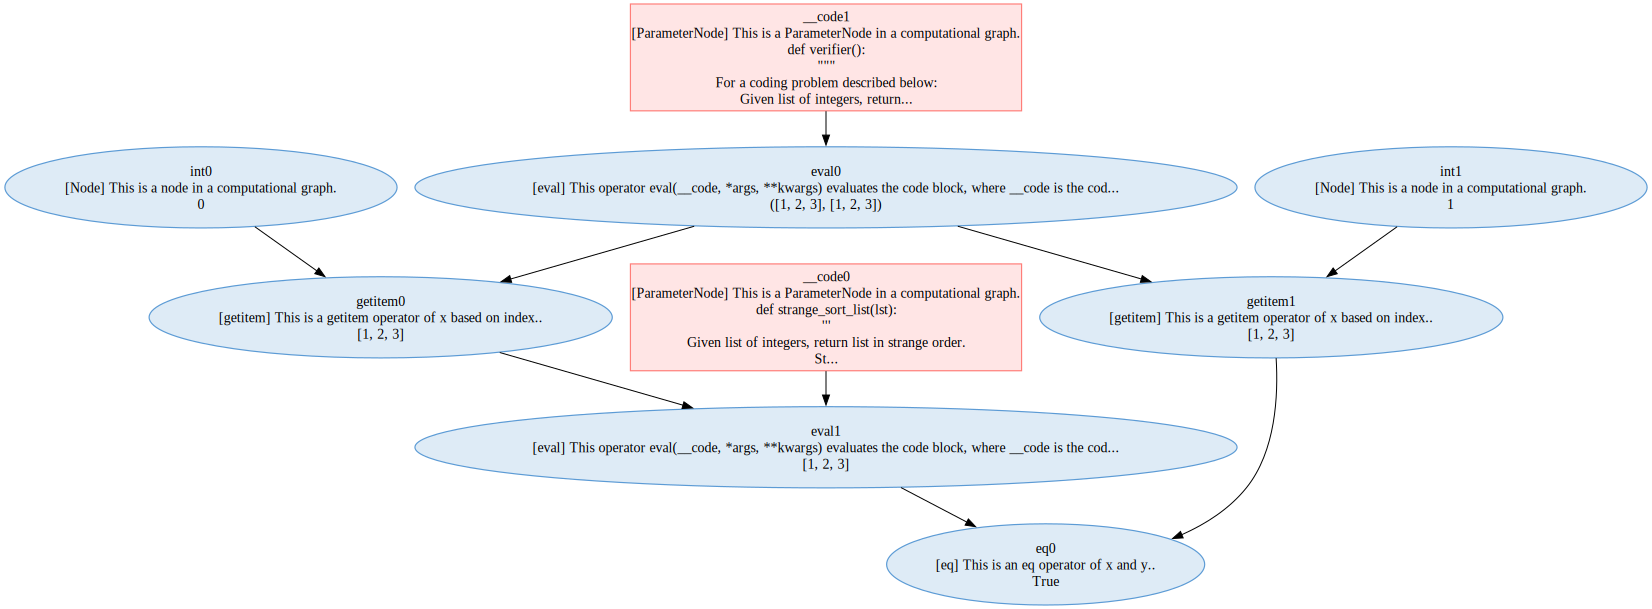

In [9]:
from opto.trace import node, bundle, GRAPH
GRAPH.clear()

@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.
    '''
    return sorted(lst)

@bundle(trainable=True)
def verifier():
    """
    For a coding problem described below:
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Return a test input and an expected output to verify if the function is implemented correctly.
    """
    test_input = [1,2,3]
    expected_output = [1,2,3]
    return test_input, expected_output

test_input, expected_output = verifier()
test_output = strange_sort_list(test_input)
print(test_output)
verifier_passed = test_output.eq(expected_output)
verifier_passed.backward("synthetic test result", visualize=True)

In [10]:
from opto.optimizers import OptoPrime

GRAPH.clear()

test_ground_truth = [1, 4, 2, 3]
test_ground_truth_input = [1, 2, 3, 4]

epoch = 2

code_optimizer = OptoPrime(strange_sort_list.parameters(), ignore_extraction_error=True)
verifier_optimizer = OptoPrime(verifier.parameters(), ignore_extraction_error=True)

for i in range(epoch):
    print(f"Training Epoch {i}")

    # Step 2: Coder optimizes till it passes the verifier
    verifier_passed = False
    while not verifier_passed:
        print(f"Code function update")
        try:
            test_input, expected_output =  verifier()
            test_output = strange_sort_list(test_input)
            # note that we use the same feedback function as before
            feedback = get_feedback(test_output.data, expected_output.data)
        except trace.ExecutionError as e:
            feedback = e.exception_node.data
            test_output = e.exception_node
            expected_output = None
        verifier_passed = test_output.eq(expected_output)
        
        code_optimizer.zero_feedback()
        code_optimizer.backward(verifier_passed, feedback, retain_graph=True)
        code_optimizer.step()

    # Step 3: Coder is checked by ground truth
    try:
        test_output = strange_sort_list(test_ground_truth_input)
        feedback = get_feedback(test_output, test_ground_truth)
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    correctness = test_output.eq(test_ground_truth)
    
    if correctness:
        break

    # Step 4: If the Coder fails, Verifier needs to propose better unit tests
    print(f"Verifier update")
    feedback = "Verifier proposed wrong test_input, expected_output that do not validate the implementation of the function."
    verifier_optimizer.zero_feedback()
    verifier_optimizer.backward(verifier_passed, feedback)
    verifier_optimizer.step()

Training Epoch 0
Code function update
Verifier update
Training Epoch 1
Code function update
Code function update


In [11]:
print(strange_sort_list.parameters()[0])

ParameterNode: (__code:0, dtype=<class 'str'>, data=def strange_sort_list(lst):
    """
    Given list of integers, return list in strange order.
    Strange sorting is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.
    """
    sorted_lst = sorted(lst)
    result = []
    while sorted_lst:
        result.append(sorted_lst.pop(0))  # Append minimum value
        if sorted_lst:  # If there are remaining elements
            result.append(sorted_lst.pop(-1))  # Append maximum value
    return result
)


In [12]:
print(verifier.parameters()[0])

ParameterNode: (__code:1, dtype=<class 'str'>, data=def verifier():
    """
    For a coding problem described below:
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum, and so on.

    Return a test input and an expected output to verify if the function is implemented correctly.
    """
    test_input = [1, 3, 2, 4]
    expected_output = [1, 4, 2, 3]  # Alternating between minimum and maximum values
    return test_input, expected_output
)
